In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import cirpy
from urllib.request import urlopen
from urllib.parse import quote
import pubchempy as pcp
from matplotlib import colors

In [2]:
octane = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\cleaned_octane_database.csv')
comb_h = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\comb_heat.csv')
boil_p = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\boiling_point.csv')
densit = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\density.csv')
entr_h = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\raw_data\entropy_heat_capacity.csv')
auto_t = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\autoignition_temp.csv')

comb_h = comb_h.rename(columns={'Smiles':'SMILES'})
boil_p = boil_p.rename(columns={'Smiles':'SMILES'})
densit = densit.rename(columns={'Smiles':'SMILES'})

print(densit.shape)

(543, 4)


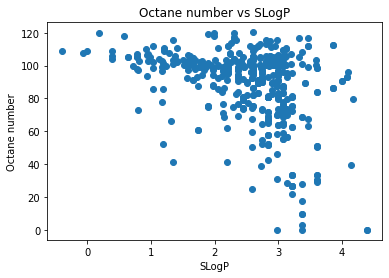

In [3]:
plt.scatter(octane['SLogP'],octane['y'])
plt.xlabel('SLogP')
plt.ylabel('Octane number') 
plt.title('Octane number vs SLogP')
plt.show()

In [4]:
comb_h.head(2)

,SMILES,?Hc°(KJ/kg)
0,C#CC(C)(C)C#C,40674.60867
1,C#CC(C)(C)CC,43242.50963


In [5]:
octane.head(2)

,Unnamed: 0,Unnamed: 0.1,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,dev,y,ron_choice,Complexity,XLogP
0,0,0,CCCCO,1-Butanol,98.0,263,"Sandia, UML",[6],N-BUTANOL,98.0,...,2,14.0,12.0,2.75,1.5,0.0,98.0,abs dev < 0.01,13.0,0.9
1,1,1,CCO,Ethanol,109.0,702,"Sandia, UML",[6],ETHANOL,109.0,...,0,6.0,4.0,2.25,1.0,0.0,109.0,abs dev < 0.01,2.0,-0.1


### Find the number of missing physical properties data between octane database and 
####

In [6]:
for df,name in zip([comb_h,boil_p,densit,entr_h,auto_t],['combustion heat','boiling point','density','entropy','autoig. temp']):
    print('Number of missing values for ' + name +' = {}'.format(pd.merge(octane,df,how='left',on='SMILES').iloc[:,-1].isnull().sum()))


Number of missing values for combustion heat = 443
Number of missing values for boiling point = 443
Number of missing values for density = 509
Number of missing values for entropy = 403
Number of missing values for autoig. temp = 396


In [7]:
len(set(octane['SMILES'].values)-set(comb_h['SMILES'].values))

443

# Complexity and XLogP

In [57]:
def X_LogP_Complexity(row):
    smi  = row['SMILES']
    prop = pcp.get_properties(['Complexity', 'XLogP'], smi, 'smiles', as_dataframe=False)[0]
    return prop['Complexity'],prop['XLogP']

In [58]:
octane[['Complexity','XLogP']] = octane.apply(X_LogP_Complexity, axis=1, result_type="expand")

In [59]:
#save results 

octane.to_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\cleaned_octane_database.csv')

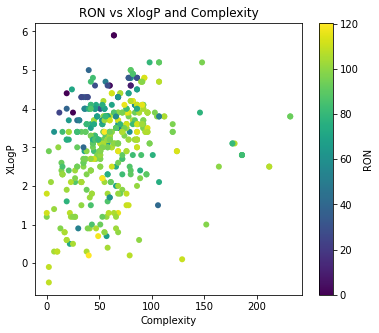

In [86]:
plt.scatter(octane['Complexity'],octane['XLogP'],edgecolors='none',c=octane['y'])
plt.xlabel('Complexity')
plt.ylabel('XLogP') 
plt.title('RON vs XlogP and Complexity')
plt.colorbar(label='RON')
plt.show()

# Boiling Point and Density

###  Knovel Data for boiling point and density 

https://app.knovel.com/web/view/itable/show.v/rcid:kpYHTPPCC4/cid:kt002UT9Q2/viewerType:itble//root_slug:Physical-Properties-and-Refractive-Index/url_slug:physical-properties-refractive?b-q=Yaws%27%20Handbook%20of%20Thermodynamic%20and%20Physical%20Properties%20of%20Chemical%20Compounds&include_synonyms=no&q=Yaws%27%20Handbook%20of%20Thermodynamic%20and%20Physical%20Properties%20of%20Chemical%20Compounds&sort_on=default&start=4950&columns=1,3,4,5,6,8,10,12,13


In [8]:
files_dir    = glob.glob(r"C:\Users\zcemg08\Desktop\bp_density\*.csv")
column_names = ['material','CAS Registry No.','mol. formula','mol. weight','freezing point (K)','boiling point (K)','density (g/cm3)','refractive index temp.','T (Â°C)','refractive index @ T', 'nD'
]

In [8]:
def to_float(x):
    if x=='""' or x =='':
        return None
    else:
        return float(x[1:-1])

def func_row(row):
    
    vals_    = row.values[0].split(';')[:9]
    
    name     = str(vals_[0])
    CAS      = str(vals_[1][1:-1])
    formular = str(vals_[2][1:-1])
    
    weight   = to_float(vals_[3])
    freez_p  = to_float(vals_[4])
    boil_p   = to_float(vals_[5])
    density  = to_float(vals_[6])
    
    refractive_index_temp = to_float(vals_[7])
    T_A                   = to_float(vals_[8])

    return name, CAS,formular,weight,freez_p,boil_p,density,refractive_index_temp,T_A


def clean_df(file_path):
    
    df                   = pd.read_csv(file_path,skiprows=[0,1,2,3,4],header=None)
    df[column_names[:9]] = df.apply(func_row,axis=1,result_type='expand')
    df                   = df.drop(0,axis=1)  
    df.drop(df.tail(3).index,inplace=True)
    
    return df


def cas_to_smiles(x):
    try:
        query = cirpy.resolve(x, 'smiles')
        if query is None:
            return None
        else:
            return query
    except:
        return None
    
    
def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return None
    
    
def name_to_smiles(name):
    try:
        smiles = pcp.get_compounds(name, 'name')[0].canonical_smiles
        return smiles
    except:
        return None

In [59]:
#concat and clean all excel pages
data_knovel = pd.concat([clean_df(x) for x in files_dir])

### Fill Smiles column by (1),(2) and (3)
# 1- CAS number to SMILES
# name to smiles by cactus.nci.nih.gov
# name to smiles by pubchem

data_knovel['SMILES']                                    = data_knovel['CAS Registry No.'].apply(cas_to_smiles)
data_knovel.loc[data_knovel['SMILES'].isnull(),'SMILES'] = data_knovel[data_knovel['SMILES'].isnull()]['material'].apply(CIRconvert)
data_knovel.loc[data_knovel['SMILES'].isnull(),'SMILES'] = data_knovel[data_knovel['SMILES'].isnull()]['material'].apply(name_to_smiles)

In [60]:
data_knovel.loc[data_knovel['SMILES'].isnull(),'SMILES'] = data_knovel[data_knovel['SMILES'].isnull()]['SMILES'].apply(CIRconvert)

In [74]:
data_knovel.loc[data_knovel['SMILES'].isnull(),'SMILES'] = data_knovel[data_knovel['SMILES'].isnull()]['SMILES'].apply(CIRconvert)

In [75]:
len(data_knovel[data_knovel['SMILES'].isnull()])/len(data_knovel)

0.23649834275687268

In [76]:
data_knovel.to_csv(r'C:\Users\zcemg08\Desktop\data\bp_density_knovel.csv')

### Load processed data for boiling point and density 

In [93]:
bp_den_knovel = pd.read_csv(r'C:\Users\zcemg08\Desktop\data\bp_density_knovel.csv')

In [17]:
bp_den_knovel.head(3)

,Unnamed: 0,material,CAS Registry No.,mol. formula,mol. weight,freezing point (K),boiling point (K),density (g/cm3),refractive index temp.,T (Â°C),SMILES
0,0,abietic acid,514-10-3,C20H30O2,302.457,446.65,649.70,NaN,NaN,NaN,CC(C)C1=CC2=CC[C@@H]3[C@](C)(CCC[C@@]3(C)C(O)=...
1,1,acenaphthene,83-32-9,C12H10,154.211,366.56,550.54,NaN,19.85,1.6420,C1Cc2cccc3cccc1c23
2,2,acetal,105-57-7,C6H14O2,118.176,173.15,376.75,0.821,25.00,1.3682,CCOC(C)OCC


In [19]:
new_df = pd.merge(octane,bp_den_knovel[['SMILES','boiling point (K)','density (g/cm3)']],how='left',on='SMILES')

In [22]:
df2 = new_df[new_df['boiling point (K)'].isnull()]

In [89]:
df3 = pd.merge(df2,boil_p[['SMILES','Boiling_point_K']],how='left',on='SMILES')

In [96]:
df3[df3['Boiling_point_K'].isnull()].head(5)

,Unnamed: 0,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,...,Zagreb1,Zagreb2,mZagreb1,mZagreb2,dev,y,ron_choice,boiling point (K),density (g/cm3),Boiling_point_K
1,5,CC1(C2CCC(O1)(CC2)C)C,"1,3,3-Trimethyl-2-oxabicyclo[2,2,2]octane",99.2,2758,Sandia,NaN,NaN,NaN,NaN,...,64.0,76.0,4.486111,2.166667,NaN,99.2,no alternative,NaN,NaN,NaN
2,10,C1C=CC2C1C3CC2C=C3,dicyclopentadiene,100.8,6492,UML,[1],NaN,NaN,NaN,...,60.0,75.0,1.944444,2.083333,NaN,100.8,no alternative,NaN,NaN,NaN
3,15,CCC(=O)C,2-Butanone,105.3,6569,"Sandia, UML",[9],NaN,NaN,NaN,...,16.0,14.0,3.361111,1.333333,0.0,105.3,abs dev < 0.01,NaN,NaN,NaN
4,17,CC1=CC[C@@H]2C[C@H]1C2(C)C,"2, 6, 6- trimethyl- , (1R, 5R) -bicyclo[3.1.1]...",80.0,6654,"Sandia, UML",[1],NaN,NaN,NaN,...,58.0,72.0,4.145833,2.027778,NaN,80.0,no alternative,NaN,NaN,NaN
5,18,C1C=CC2=CC=CC=C21,indene,102.3,7219,Sandia,NaN,NaN,NaN,NaN,...,46.0,53.0,1.972222,2.027778,NaN,102.3,no alternative,NaN,NaN,NaN


# Autoiginition Tempearture 

### 1st folder

In [232]:
files_auto1    = glob.glob(r"C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_1\*.csv")

In [233]:
def func_row_1(row):
    
    vals_    = row.values[0].split(';')[:6]
    x1       = str(vals_[0])
    
    x2       = to_float(vals_[1][1:-1])
    x3       = to_float(vals_[2][1:-1])
    x4       = to_float(vals_[3][1:-1])
    x5       = to_float(vals_[4][1:-1])
    
    x6       = str(vals_[5][1:-1])

    return x1,x2,x3,x4,x5,x6


In [263]:
def clean_auto1(link_):
    
    df     = pd.read_csv(link_,skiprows=[0,1,2,3,4],header=None)
    header = df.loc[:6,0].values[:6]
    
    df = df.drop([0,1,2,3,4,5],axis=0)
    df = df.drop(1,axis=1)
    df.drop(df.tail(3).index,inplace=True)
    
    df[header] = df.apply(func_row_1,axis=1,result_type='expand')
    df = df.rename({header[-1]:'reference'})
    df = df.drop(0,axis=1)
    
    return df


def bracket(str_):
    if '(' in str_:
        name = str_.split('(')[0]
        return name
    else:
        return str_

In [264]:
df_auto1 = pd.concat([clean_auto1(x) for x in files_auto1])

In [266]:
df_auto1['SMILES'] = df_auto1.iloc[:,0].apply(lambda x: name_to_smiles(bracket(x)))

In [270]:
df_auto1[df_auto1['SMILES'].isnull()].shape

(80, 6)

In [276]:
df_auto1.reset_index(inplace=True)

In [277]:
df_auto1

,index,"autoignition temperature (°C)"";""lowest reported AIT","autoignition temperature (°F)"";""lowest reported AIT",autoignition temperature,"if other than glass or unspecified (°C)"";""lowest reported AIT","if other than glass or unspecified (°F)"";""reference"";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";""""",SMILES
0,6,Methane,NaN,9.0,3.0,17,C
1,7,Ethane,1.0,8.0,7.0,,CC
2,8,Butane,7.0,4.0,5.0,1,CCCC
3,9,Propane,9.0,5.0,8.0,,CCC
4,10,Pentane,5.0,7.0,4.0,,CCCCC
...,...,...,...,...,...,...,...
408,14,Trichloroethylene,2.0,8.0,1.0,14,C(=C(Cl)Cl)Cl
409,15,Propene (propylene),NaN,5.0,5.0,13,CC=C
410,16,2-Hexanone (methyl butyl ketone),NaN,9.0,3.0,13,CCCCC(=O)C
411,17,2-Methylundecane,NaN,3.0,0.0,12,CCCCCCCCCC(C)C


In [285]:
df_auto1.loc[df_auto1['SMILES'].isnull(),'SMILES'] = df_auto1.iloc[(df_auto1['SMILES'].isnull()).index,1].apply(CIRconvert)

In [287]:
df_auto1[df_auto1['SMILES'].isnull()]

,index,"autoignition temperature (°C)"";""lowest reported AIT","autoignition temperature (°F)"";""lowest reported AIT",autoignition temperature,"if other than glass or unspecified (°C)"";""lowest reported AIT","if other than glass or unspecified (°F)"";""reference"";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";"""";""""",SMILES
43,49,4-lsopropylheptane,NaN,9.0,5.0,20,None
76,32,"2,2,4-Trimethyl-1-pentene",7.0,NaN,NaN,6,None
89,45,lsopropylbenzene (cumene),2.0,NaN,NaN,2,None
91,47,lsobutyl benzene,2.0,NaN,NaN,2,None
95,51,"1,3-DimethyIbenzene (m-xylene)",2.0,NaN,NaN,2,None
...,...,...,...,...,...,...,...
390,46,"Bicyclo (2,2,1) heptene-2",0.0,NaN,NaN,15,None
393,49,"1,4,5,8-DiendomethyIeneocta-hydronaphthalene",0.0,NaN,NaN,15,None
399,55,lsopropylcyclohexane,8.0,NaN,NaN,15,None
400,6,Butylcyclohexdne,4.0,NaN,NaN,15,None


In [288]:
df_auto1.to_csv(r'C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_1\auto_combine1.csv')

### 2nd folder 

In [14]:
files_auto2    = glob.glob(r"C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_2\*.csv")[1:]

In [16]:
def func_row_2(row):
    
    vals_    = row.values[0].split(';')[:9]
    
    x1       = str(vals_[0][1:-1])
    x2       = str(vals_[1][1:-1])
    x3       = str(vals_[2][1:-1])
    x4       = str(vals_[3][1:-1])
    
    x5       = to_float(vals_[4])
    x6       = to_float(vals_[5])
    x7       = to_float(vals_[6])
    x8       = to_float(vals_[7])
    x9       = to_float(vals_[8])

    return x1,x2,x3,x4,x5,x6,x7,x8,x9

In [17]:
def clean_auto2(link_):
    
    header = ['formular','compound','synonyms','CAS Registry No.',\
             'mol_weight','auto_temp_K','auto_temp_C','auto_temp_F','code']
    
    df     = pd.read_csv(link_,skiprows=[0,1,2,3],header=None,sep='delimiter')
    
    df = df.drop([0,1,2,3],axis=0)
    df.drop(df.tail(3).index,inplace=True)
    
    df[header] = df.apply(func_row_2,axis=1,result_type='expand')
    
    df = df.drop(0,axis=1)
    
    
    return df

In [18]:
df_auto2 = pd.concat([clean_auto2(x) for x in files_auto2])

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [20]:
df_auto2

,formular,compound,synonyms,CAS Registry No.,mol_weight,auto_temp_K,auto_temp_C,auto_temp_F,code
4,CH2Cl2,dichloromethane,view synonyms,1975-09-02,84.932,888.15,615.0,1139.0,1.0
5,CH2O,formaldehyde,view synonyms,1950-07-14,30.026,703.15,430.0,806.0,1.0
6,CH2O2,formic acid,view synonyms,64-18-6,46.026,753.00,479.9,895.7,1.0
7,CH3Br,methyl bromide,view synonyms,74-83-9,94.939,810.37,537.2,999.0,1.0
8,CH3Cl,methyl chloride,view synonyms,74-87-3,50.487,905.00,631.9,1169.3,1.0
...,...,...,...,...,...,...,...,...,...
46,C7H16O,2-heptanol,view synonyms,543-49-7,116.203,573.00,299.9,571.7,2.0
47,C7H16O,2-methyl-1-hexanol,view synonyms,624-22-6,116.203,541.00,267.9,514.1,2.0
48,C7H16O4,triethylene glycol monomethyl ether,view synonyms,112-35-6,164.202,475.00,201.9,395.3,2.0
49,C8H4O3,phthalic anhydride,view synonyms,85-44-9,148.118,857.04,583.9,1083.0,1.0


In [21]:
df_auto2['SMILES']=df_auto2['CAS Registry No.'].apply(cas_to_smiles)

In [22]:
df_auto2.loc[df_auto2['SMILES'].isnull(),'SMILES'] = df_auto2.loc[df_auto2['SMILES'].isnull(),'compound'].apply(name_to_smiles)

In [26]:
df_auto2.loc[df_auto2['SMILES'].isnull(),'SMILES'] = df_auto2.loc[df_auto2['SMILES'].isnull(),'compound'].apply(CIRconvert)

In [27]:
df_auto2.loc[df_auto2['SMILES'].isnull()] 

,formular,compound,synonyms,CAS Registry No.,mol_weight,auto_temp_K,auto_temp_C,auto_temp_F,code,SMILES
29,C6H6N2,cis-dicyano-1-butene,view synonyms,2141-58-4,106.128,649.0,375.9,708.5,2.0,None
30,C6H6N2,trans-dicyano-1-butene,view synonyms,2141-59-5,106.128,649.0,375.9,708.5,2.0,None


In [28]:
df_auto2.to_csv(r'C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_2\auto_combine2.csv')

In [41]:
pd

,Unnamed: 0,Unnamed: 0.1,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,dev,y,ron_choice,Complexity,XLogP
0,0,0,CCCCO,1-Butanol,98.00,263,"Sandia, UML",[6],N-BUTANOL,98.0,...,2,14.0,12.0,2.750000,1.500000,0.000000,98.00,abs dev < 0.01,13.0,0.9
1,1,1,CCO,Ethanol,109.00,702,"Sandia, UML",[6],ETHANOL,109.0,...,0,6.0,4.0,2.250000,1.000000,0.000000,109.00,abs dev < 0.01,2.0,-0.1
2,2,2,CO,Methanol,109.00,887,"Sandia, UML",[11],METHANOL,122.0,...,0,2.0,1.0,2.000000,1.000000,0.059633,109.00,WIKIPEDIA 108.7,2.0,-0.5
3,3,3,CCCO,n-Propanol,104.00,1031,"Sandia, UML",[6],N-PROPANOL,104.0,...,1,10.0,8.0,2.500000,1.250000,0.000000,104.00,abs dev < 0.01,7.0,0.3
4,4,4,CC1=CC=CC=C1,Toluene,118.17,1140,"Sandia, UML","[1], [3]",NaN,NaN,...,5,30.0,31.0,2.361111,1.666667,NaN,118.17,no alternative,42.0,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,487,487,CC=C(C)C(C)(C)C,NaN,NaN,11738,NaN,NaN,NaN,NaN,...,8,34.0,35.0,5.423611,1.833333,NaN,103.00,no alternative,91.0,3.6
488,488,488,CCCC=CCCC,NaN,NaN,11621,NaN,NaN,NaN,NaN,...,5,26.0,24.0,3.500000,2.250000,NaN,73.30,no alternative,45.0,3.6
489,489,489,CCC(C)(C)CC=C,NaN,NaN,137136,NaN,NaN,NaN,NaN,...,7,32.0,32.0,4.812500,2.000000,NaN,79.80,no alternative,70.0,3.6
490,490,490,CCCCCCCC,NaN,NaN,356,NaN,NaN,NaN,NaN,...,5,26.0,24.0,3.500000,2.250000,NaN,0.00,no alternative,25.0,3.9


In [45]:
df_auto2

,formular,compound,synonyms,CAS Registry No.,mol_weight,auto_temp_K,auto_temp_C,auto_temp_F,code,SMILES
4,CH2Cl2,dichloromethane,view synonyms,1975-09-02,84.932,888.15,615.0,1139.0,1.0,C(Cl)Cl
5,CH2O,formaldehyde,view synonyms,1950-07-14,30.026,703.15,430.0,806.0,1.0,C=O
6,CH2O2,formic acid,view synonyms,64-18-6,46.026,753.00,479.9,895.7,1.0,OC=O
7,CH3Br,methyl bromide,view synonyms,74-83-9,94.939,810.37,537.2,999.0,1.0,CBr
8,CH3Cl,methyl chloride,view synonyms,74-87-3,50.487,905.00,631.9,1169.3,1.0,CCl
...,...,...,...,...,...,...,...,...,...,...
46,C7H16O,2-heptanol,view synonyms,543-49-7,116.203,573.00,299.9,571.7,2.0,CCCCCC(C)O
47,C7H16O,2-methyl-1-hexanol,view synonyms,624-22-6,116.203,541.00,267.9,514.1,2.0,CCCCC(C)CO
48,C7H16O4,triethylene glycol monomethyl ether,view synonyms,112-35-6,164.202,475.00,201.9,395.3,2.0,COCCOCCOCCO
49,C8H4O3,phthalic anhydride,view synonyms,85-44-9,148.118,857.04,583.9,1083.0,1.0,O=C1OC(=O)c2ccccc12


In [43]:
df_a1 = pd.merge(octane,auto_t[['SMILES','Temp']],how='left',on='SMILES')

In [46]:
df_a2 = pd.merge(df_a1,df_auto2[['SMILES','auto_temp_K']],how='left',on='SMILES')

In [47]:
octane.shape

(492, 895)

In [51]:
df_a2[(df_a2['Temp'].notnull()) & (df_a2['auto_temp_K'].isnull())]

,Unnamed: 0,Unnamed: 0.1,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,...,Zagreb2,mZagreb1,mZagreb2,dev,y,ron_choice,Complexity,XLogP,Temp,auto_temp_K
87,87,87,CC#CC,dimethylacetylene,85.9,10419,"Sandia, UML",[1],2-Butyne,85.9,...,8.0,2.500000,1.250000,0.000000,85.9,abs dev < 0.01,42.0,1.5,596.0,NaN
131,131,131,C=CCCC=C,"1,5-hexadiene",71.1,11598,"Sandia, UML",[1],"1,5-Hexadiene",71.1,...,16.0,3.000000,1.750000,0.000000,71.1,abs dev < 0.01,36.0,2.9,592.0,NaN
154,154,154,CCCCCCC#C,1-octyne,50.5,12370,"Sandia, UML",[1],1-Octyne,50.5,...,24.0,3.500000,2.250000,0.000000,50.5,abs dev < 0.01,73.0,3.5,517.0,NaN
159,159,159,C=CC1CCCCC1,vinylcyclohexane,64.3,12757,UML,[1],Vinylcyclohexane,64.3,...,36.0,2.611111,2.000000,0.000000,64.3,abs dev < 0.01,68.0,3.6,543.0,NaN
161,161,161,CCC(C)C=C,3-Methyl-1-Pentene,96.0,12969,"Sandia, UML",[1],NaN,NaN,...,19.0,3.611111,1.666667,0.000000,96.0,abs dev < 0.01,37.0,2.7,625.0,NaN
196,196,196,C[C@@H]1CCCC[C@@H]1C,"cis-1,2-dimethylcyclohexane",80.9,16628,Sandia,NaN,NaN,NaN,...,39.0,3.222222,1.861111,NaN,80.9,no alternative,56.0,3.8,577.0,NaN
204,204,204,CC(C)(C)C1CCCCC1,tert-butylcyclohexane,98.5,18508,UML,[1],NaN,NaN,...,52.0,4.423611,2.166667,0.000000,98.5,abs dev < 0.01,91.0,4.7,613.0,NaN
206,206,206,CCCC(C)C=C,3-Methyl-1-Hexene,82.2,18848,"Sandia, UML",[1],NaN,NaN,...,23.0,3.861111,1.916667,0.000000,82.2,abs dev < 0.01,46.0,3.3,578.0,NaN
217,216,216,CC(C)CCCC=C,6-methyl-1-heptene,63.6,21122,UML,[1],NaN,NaN,...,26.0,4.111111,2.083333,0.001572,63.6,abs dev < 0.01,53.0,3.7,547.0,NaN
220,219,219,C[C@@H]1CCCC[C@H]1C,"trans-1,2-dimethylcyclohexane",80.9,23313,Sandia,NaN,NaN,NaN,...,39.0,3.222222,1.861111,NaN,80.9,no alternative,56.0,3.8,577.0,NaN


### 3d folder

In [29]:
files_auto3    = glob.glob(r"C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_3\*.csv")

In [33]:
df_100 = pd.read_csv(files_auto3[0],skiprows=[0,1,2,3,4],header=None,sep='delimiter')

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [40]:
df_100.iloc[7].values[0].split(';')[:11]

['"acetic anhydride"',
 '"view synonyms"',
 '"C4H6O3"',
 '"108-24-7"',
 '"2.9"',
 '"10.3"',
 '"experimental"',
 '"129"',
 '"experimental"',
 '"734"',
 '"experimental"']

In [ ]:
def func_row_2(row):
    
    vals_    = row.values[0].split(';')[:11]
    
    x1       = str(vals_[0][1:-1])
    x2       = str(vals_[1][1:-1])
    x3       = str(vals_[2][1:-1])
    x4       = str(vals_[3][1:-1])
    
    x5       = to_float(vals_[4])
    x6       = to_float(vals_[5])
    x7       = to_float(vals_[6])
    x8       = to_float(vals_[7])
    x9       = to_float(vals_[8])

    return x1,x2,x3,x4,x5,x6,x7,x8,x9